In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import math

In [32]:
# fix numpy seed
np.random.seed(514)

In [33]:
# read data
df = pd.read_csv('../dat/train.csv', sep=',')

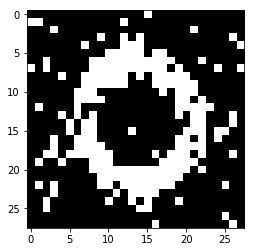

In [56]:
# pick up one image
TARGET = 1
lab = df.iloc[TARGET,0]
img = df.iloc[TARGET,1:].as_matrix()
img = img.astype(np.uint8)

# set threshold for images
THRESHOLD = 128
img[img < THRESHOLD] = 0
img[img >= THRESHOLD] = 255

# build ground truth matrix into {-1, +1}
gmat = img.astype(np.int64)
gmat = gmat / 255 * 2 - 1

# flip 10% at random
idx = np.random.choice(range(784), 78, replace=False)
rev_idx = list(np.setdiff1d(np.array(range(784)), idx))
img[idx] = 255-img[idx]

# reshape array into image
img = img.reshape((28,28))
plt.imshow(img,cmap=cm.gray)
plt.savefig('../res/origin.png')

# map matrix into {-1, +1}
mat = img.astype(np.int64)
mat = mat / 255 * 2 - 1

In [52]:
def calACC(pmat, gmat, idx):
    ret = 0.0
    pmax = pmat.flatten() >= 0
    gmat = gmat >= 0
    
    for i in idx:
        if pmax[i] == gmat[i]:
            ret += 1.0
    return ret / len(idx)

Perturbed Pixels: 0.820513
Unperturbed Pixels: 0.991501
Overall: 0.974490


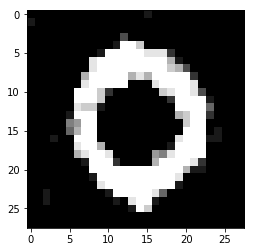

In [57]:
# Gibbs Sampler Implementation
NUM_ITER = 10
CONST = 1

bmat = mat * CONST
tmat = np.zeros((28,28))

for t in range(NUM_ITER):
    for i in range(28):
        for j in range(28):
            p0 = -bmat[i][j]
            p1 = +bmat[i][j]
            if i > 0:
                p0 += -1 * mat[i-1][j]
                p1 += +1 * mat[i-1][j]
            if i < 27:
                p0 += -1 * mat[i+1][j]
                p1 += +1 * mat[i+1][j]
            if j > 0:
                p0 += -1 * mat[i][j-1]
                p1 += +1 * mat[i][j-1]
            if j < 27:
                p0 += -1 * mat[i][j+1]
                p1 += +1 * mat[i][j+1]
            p0 = p0
            p1 = p1
            
            if p0 < p1:
                ep1 = math.exp(p1-p0) / (1 + math.exp(p1-p0))
            else:
                ep1 = 1.0 / (1 + math.exp(p0-p1))

            nv = np.random.choice([-1, +1], 1, p=[1-ep1, ep1])
            mat[i][j] = nv
    
    tmat += mat

# average the result    
tmat /= 10

# calculate accuracy
print 'Perturbed Pixels: %f' % calACC(tmat, gmat, idx)
print 'Unperturbed Pixels: %f' % calACC(tmat, gmat, rev_idx)
print 'Overall: %f' % calACC(tmat, gmat, range(784))

# map matrix into {0, 255}
tmat = (tmat + 1) / 2 * 255
img = tmat.astype(np.uint8)
plt.imshow(img,cmap=cm.gray)
plt.savefig('../res/gibbs_sampling.png')

Perturbed Pixels: 0.858974
Unperturbed Pixels: 0.974504
Overall: 0.963010


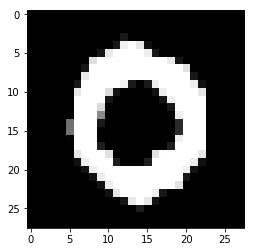

In [58]:
# Mean Field Algorithm Implementation
NUM_ITER = 10
CONST = 1

bmat = mat * CONST
mmat = np.random.uniform(-1.0, +1.0, (28,28))

for t in range(NUM_ITER):
    for i in range(28):
        for j in range(28):
            a = bmat[i,j]
            if i > 0:
                a += mmat[i-1,j]
            if i < 27:
                a += mmat[i+1,j]
            if j > 0:
                a += mmat[i,j-1]
            if j < 27:
                a += mmat[i,j+1]
            mmat[i,j] = np.tanh(a)
            
# calculate accuracy
print 'Perturbed Pixels: %f' % calACC(mmat, gmat, idx)
print 'Unperturbed Pixels: %f' % calACC(mmat, gmat, rev_idx)
print 'Overall: %f' % calACC(mmat, gmat, range(784))            

# map matrix into {0, 255}
mmat = (mmat + 1) / 2 * 255
img = mmat.astype(np.uint8)
plt.imshow(img,cmap=cm.gray)
plt.savefig('../res/mean_field.png')